# Corona Virus Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline
sbn.set(rc={'figure.figsize':(11.7,8.27)})


In [2]:
rawData = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
rawData.head(5)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [3]:
dataFrames = dict(states={}, counties={})
columns = ['cases', 'deaths']

def getTotal(): 
    if not "total" in dataFrames:
        dataFrames["total"] =rawData.groupby('date').sum()[columns]
    return dataFrames["total"]

def getState(state):
    if not state in dataFrames["states"]:
        statedf = rawData[rawData.state==state].groupby('date').sum()[columns]
        if statedf.empty:
            print (state + " is not in the data, did you spell it right? capitalization?")
            return 
        else:
            dataFrames["states"][state] = statedf
    return dataFrames["states"][state]

def getCounty(county):
    if not county in dataFrames["counties"]:
        countydf = rawData[rawData.county==county].groupby('date').sum()[columns]
        if countydf.empty:
            print(county + " is not in the data, did you spell it right? capitalization?")
            return
        else:
            dataFrames["counties"][county] = countydf
    return dataFrames["counties"][county]
        

In [4]:
yesterday, today = getTotal().tail(2).index.values # last two dates data to check how recent this data is
print("Latest date: ", today)

Latest date:  2020-06-09


In [5]:

yesterdayLatest = rawData[rawData.date == yesterday].groupby(['state', 'county']).sum()[columns]
latest = rawData[rawData.date == today].groupby(['state', 'county']).sum()[columns]
deltas = latest - yesterdayLatest
latest["newcases"] = deltas.cases
latest["newdeaths"] = deltas.deaths
latest = latest.reset_index()

In [6]:
def worstPlaces(state=None, count=15):
    if state == None:
        count = 30
        print(f"Counties with the most new cases in US for {today}:")
        display(latest.sort_values(['newcases', 'newdeaths'], ascending=False)[:count].reset_index(drop=True))
        print(f"Counties with the most new deaths in US for {today}:")
        display(latest.sort_values(['newdeaths', 'newcases'], ascending=False)[:count].reset_index(drop=True))
    else:
        print(f"Counties with the most new cases in {state} for {today}:")
        display(latest[latest.state==state].sort_values(['newcases', 'newdeaths'], ascending=False)[:count].reset_index(drop=True))
        print(f"Counties with the most new deaths in {state} for {today}:")
        display(latest[latest.state==state].sort_values(['newdeaths', 'newcases'], ascending=False)[:count].reset_index(drop=True))


In [7]:
worstPlaces()

Counties with the most new cases in US for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,California,Los Angeles,65822,2707,1178.0,52.0
1,Illinois,Cook,83271,4010,452.0,51.0
2,California,Riverside,9590,365,384.0,9.0
3,Arizona,Maricopa,14374,504,371.0,13.0
4,New York,New York City,212469,21396,347.0,40.0
5,Texas,Harris,15238,262,320.0,0.0
6,Texas,Dallas,12645,271,298.0,7.0
7,Florida,Miami-Dade,19979,774,224.0,7.0
8,Nevada,Clark,7804,365,212.0,2.0
9,Florida,Palm Beach,7516,388,189.0,15.0


Counties with the most new deaths in US for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,California,Los Angeles,65822,2707,1178.0,52.0
1,Illinois,Cook,83271,4010,452.0,51.0
2,New York,New York City,212469,21396,347.0,40.0
3,Michigan,Wayne,21533,2651,78.0,18.0
4,Georgia,Fulton,4925,272,38.0,16.0
5,Florida,Palm Beach,7516,388,189.0,15.0
6,Pennsylvania,Philadelphia,23822,1436,131.0,15.0
7,Missouri,St. Louis,5345,480,44.0,14.0
8,Arizona,Maricopa,14374,504,371.0,13.0
9,Pennsylvania,Montgomery,7672,740,62.0,13.0


In [8]:
worstPlaces("California")

Counties with the most new cases in California for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,California,Los Angeles,65822,2707,1178.0,52.0
1,California,Riverside,9590,365,384.0,9.0
2,California,San Bernardino,6417,224,170.0,0.0
3,California,Tulare,2381,94,161.0,0.0
4,California,Orange,7786,185,143.0,8.0
5,California,San Diego,8792,312,110.0,0.0
6,California,Imperial,3133,37,85.0,0.0
7,California,Kern,2880,50,76.0,3.0
8,California,Fresno,2286,48,70.0,2.0
9,California,Kings,1637,6,70.0,0.0


Counties with the most new deaths in California for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,California,Los Angeles,65822,2707,1178.0,52.0
1,California,Riverside,9590,365,384.0,9.0
2,California,Orange,7786,185,143.0,8.0
3,California,Alameda,4006,110,40.0,6.0
4,California,San Mateo,2437,93,38.0,5.0
5,California,Santa Clara,3017,150,44.0,4.0
6,California,Kern,2880,50,76.0,3.0
7,California,Contra Costa,1774,43,68.0,3.0
8,California,Fresno,2286,48,70.0,2.0
9,California,San Joaquin,1308,39,64.0,2.0


In [9]:
worstPlaces("Colorado")

Counties with the most new cases in Colorado for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,Colorado,Denver,6176,349,38.0,1.0
1,Colorado,Arapahoe,4687,329,24.0,3.0
2,Colorado,Adams,3627,140,22.0,2.0
3,Colorado,El Paso,1880,99,18.0,1.0
4,Colorado,Jefferson,2398,185,14.0,3.0
5,Colorado,Douglas,764,47,7.0,0.0
6,Colorado,Alamosa,101,2,6.0,0.0
7,Colorado,Weld,2604,135,6.0,0.0
8,Colorado,Boulder,1027,67,5.0,0.0
9,Colorado,Larimer,632,28,4.0,0.0


Counties with the most new deaths in Colorado for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,Colorado,Arapahoe,4687,329,24.0,3.0
1,Colorado,Jefferson,2398,185,14.0,3.0
2,Colorado,Adams,3627,140,22.0,2.0
3,Colorado,Denver,6176,349,38.0,1.0
4,Colorado,El Paso,1880,99,18.0,1.0
5,Colorado,Pueblo,323,19,3.0,1.0
6,Colorado,Douglas,764,47,7.0,0.0
7,Colorado,Alamosa,101,2,6.0,0.0
8,Colorado,Weld,2604,135,6.0,0.0
9,Colorado,Boulder,1027,67,5.0,0.0


In [10]:
worstPlaces("Arizona")

Counties with the most new cases in Arizona for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,Arizona,Maricopa,14374,504,371.0,13.0
1,Arizona,Yuma,2378,28,121.0,2.0
2,Arizona,Pinal,1164,41,37.0,0.0
3,Arizona,Santa Cruz,733,6,35.0,0.0
4,Arizona,Navajo,2253,72,24.0,0.0
5,Arizona,Apache,1747,49,15.0,0.0
6,Arizona,Yavapai,340,6,10.0,0.0
7,Arizona,Pima,3161,212,7.0,7.0
8,Arizona,Cochise,156,5,7.0,0.0
9,Arizona,La Paz,189,2,6.0,0.0


Counties with the most new deaths in Arizona for 2020-06-09:


,state,county,cases,deaths,newcases,newdeaths
0,Arizona,Maricopa,14374,504,371.0,13.0
1,Arizona,Pima,3161,212,7.0,7.0
2,Arizona,Yuma,2378,28,121.0,2.0
3,Arizona,Pinal,1164,41,37.0,0.0
4,Arizona,Santa Cruz,733,6,35.0,0.0
5,Arizona,Navajo,2253,72,24.0,0.0
6,Arizona,Apache,1747,49,15.0,0.0
7,Arizona,Yavapai,340,6,10.0,0.0
8,Arizona,Cochise,156,5,7.0,0.0
9,Arizona,La Paz,189,2,6.0,0.0


In [11]:
def fitExponential(series):
    series = series.dropna()
    series = series[series>0]
    logseries = np.log(series)
    n = len(logseries)
    rate, intercept = np.polyfit(np.arange(n), logseries, 1) 
    base = np.exp(intercept)
    return (rate, base, n) 


In [12]:
def plotFitted(series, name, log=True): 
    (rate, base, n) = fitExponential(series)
    x = np.arange(n)
    series = series[-n:]
    if log:
        plt.semilogy()
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    sbn.scatterplot(x, series, label=f"{name} actual")
    sbn.lineplot(x, base * np.exp(rate*x) , label=f"{name} expected with constant exponential growth")
    plt.show()

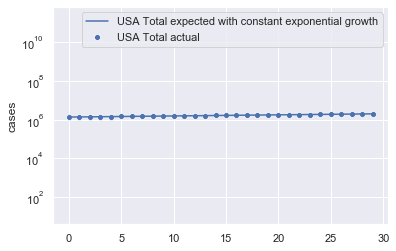

In [13]:
plotFitted(getTotal()["cases"][-30:], "USA Total")

In [14]:
def growthRateAnalysis(series, name, n=30):
    rate, base, n = fitExponential(series[-n:])
    name = f"{name} {series.name}"
    formula = f"{series.name} = {np.round(base, 2)} * exp({np.round(rate, 4)} * day)"
    dailyGrowth = np.round(100 * (np.exp(rate) - 1), 2)
    daysToDoubling = np.round(np.log(2)/rate, 2)
    print(f"{name} exponential formula fitted with {n} points:")
    print(formula)
    print(f"fitted daily growth rate: {dailyGrowth} %, fitted days to doubling: {daysToDoubling}")
    deltas = series.diff(1)
    rates = 100*deltas/series
    data = {
        f"{name} day to day growth rate (%)":rates, 
        f"{name} 3 day moving average":rates.rolling(window=3).mean(), 
        f"{name} 5 day moving average":rates.rolling(window=5).mean(), 
    }
    df = pd.DataFrame(data).dropna()[-n:]
    gr = df.tail(1)[f"{name} 5 day moving average"].values[0]
    dailyGrowth = np.round(gr, 2)
    daysToDoubling = np.round(np.log(2)*100/gr, 2)
    print(f"actual daily growth rate: {dailyGrowth} %, actual days to doubling: {daysToDoubling}")    
    sbn.lineplot(data=df)
    plt.show()
    plotFitted(series[-n:], name)


Total USA cases exponential formula fitted with 30 points:
cases = 1377562.19 * exp(0.0132 * day)
fitted daily growth rate: 1.33 %, fitted days to doubling: 52.61
actual daily growth rate: 1.1 %, actual days to doubling: 63.07


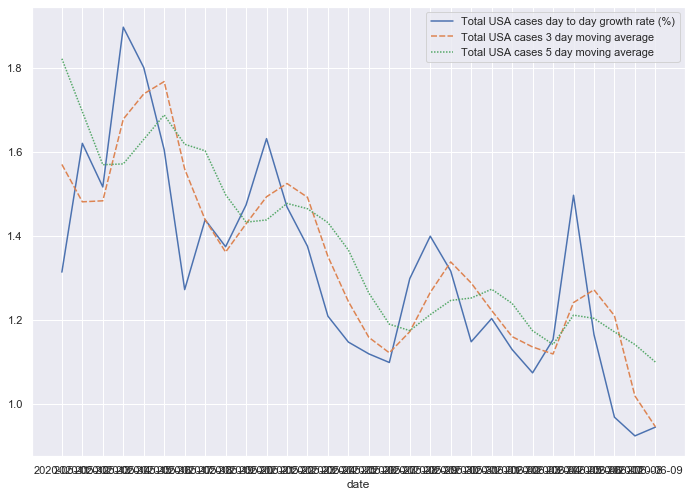

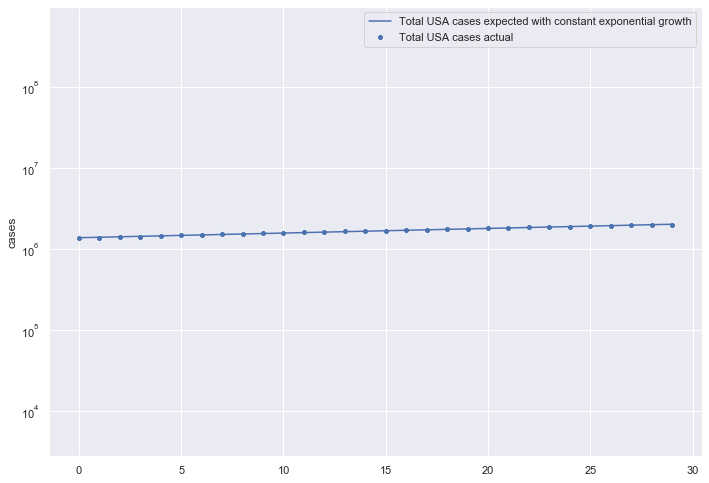

In [15]:
growthRateAnalysis(getTotal()['cases'], "Total USA")

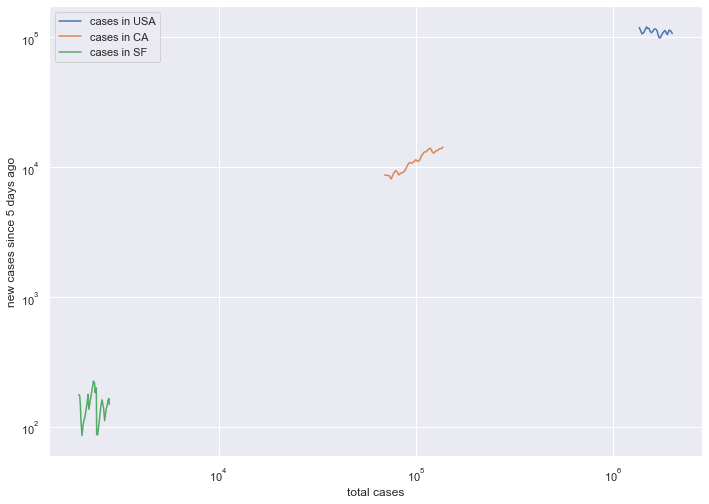

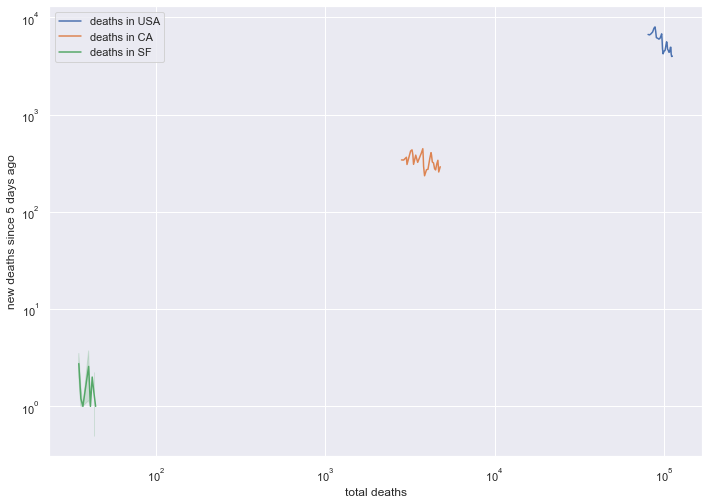

In [16]:
def trajectoryPlot(series, name):
    deltas = series.diff(5)
    fullname = f"{series.name} in {name}"
    x = f"total {series.name}"
    y = f"new {series.name} since 5 days ago"
    data = {x: series, y: deltas}
    plt.loglog()
    df = pd.DataFrame(data).dropna()[-30:]
    sbn.lineplot(x, y, data=df, label=fullname)
    
trajectoryPlot(getTotal()['cases'], "USA")
trajectoryPlot(getState("California")['cases'], "CA")
trajectoryPlot(getCounty("San Francisco")["cases"], "SF")
plt.show()
trajectoryPlot(getTotal()['deaths'], "USA")
trajectoryPlot(getState("California")['deaths'], "CA")
trajectoryPlot(getCounty("San Francisco")["deaths"], "SF")
plt.show()

In [17]:
def laggedPlot(df, name):
    vals = df.copy()
    vals = df.dropna()[df.cases > 0]
    # show correlation with wide range of time lags
    for i in range(30):
        vals[i] = df.cases.shift(i)
    vals = vals.drop(columns='cases')
    vals = vals[vals.deaths > 0][-20:]
    corrs = vals.corr()[['deaths']].drop('deaths')
    lc = np.log(vals).corr()[['deaths']].drop('deaths')
    lc[0] = lc.deaths
    for i in [3, 5, 7]:
        lc[i] = lc.deaths.rolling(i).mean()
    lc = lc.dropna()
    corrdata = {
        f"{name} correlation of log of deaths to log of cases by # of days ago": lc[0],
        f"{name} correlation 3 day moving average": lc[3],
        f"{name} correlation 5 day moving average": lc[5],
        f"{name} correlation 7 day moving average": lc[7],
    }
    corrsdf = pd.DataFrame(corrdata)
    print(f"Correlations for {name}:")
    sbn.lineplot(data=corrsdf)
    plt.show()
    # dig deeper into an interesting set of time lags
    values = vals[["deaths"]].copy()
    ratios = vals[["deaths"]].copy()
    interesting = [7, 14]
    for i in [0, 3, 5, 7]:
        l = lc[i].dropna()
        lmax = l[l==max(l)] # max at this correlation moving average
        interesting += list(lmax.index)
    for i in sorted(list(set(interesting))):
        values[f"{name} cases {i} days ago"] = vals[i]
        ratios[f"{name} deaths/cases {i} days ago"] = vals.deaths/vals[i]
    ratios = ratios.drop(columns=['deaths'])
    print(f"Deaths vs Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=values, dashes=False)
    plt.show()
    print(f"Deaths / Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=ratios, dashes=False)
    plt.show()

    

In [18]:
# laggedPlot(getTotal(), "USA")
# laggedPlot(getState("California"), "CA")
# laggedPlot(getCounty("San Francisco"), "SF")

In [19]:
def analyse(counties=[], states=[], n=20):
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    names = counties + states + ["USA total:"]
    rates= []
    dfs = [getCounty(c) for c in counties] + [getState(s) for s in states] + [getTotal()] 
    print("Trajectory Plots to see if the curve is flattening:")
    for col in ["cases", "deaths"]:
        for df, name in zip(dfs, names):
            trajectoryPlot(df[col], name)
        plt.show()
    for df, name in zip(dfs, names):
        print(f"\n### Analysis for {name:} ###\n")
        growthRateAnalysis(df["cases"], name)
        growthRateAnalysis(df["deaths"], name)
        print(f"Trajectory plots for {name}, to see when the curve starts flattening")
        trajectoryPlot(df.cases, name)
        trajectoryPlot(df.deaths, name)
        plt.show()
#         laggedPlot(df, name)


        
    
    

Trajectory Plots to see if the curve is flattening:


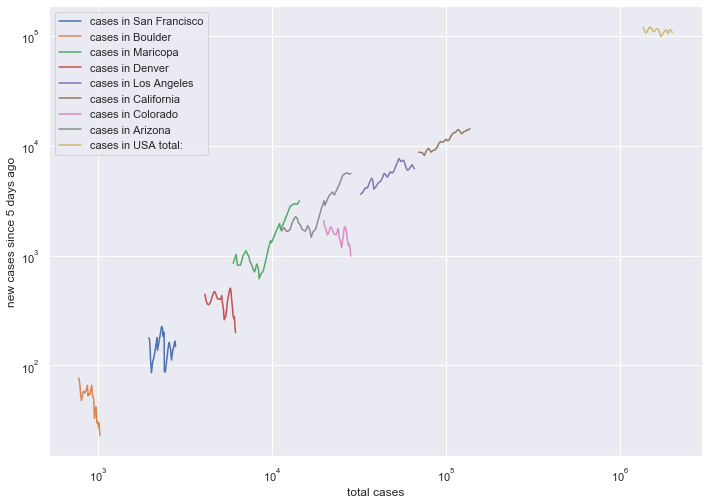

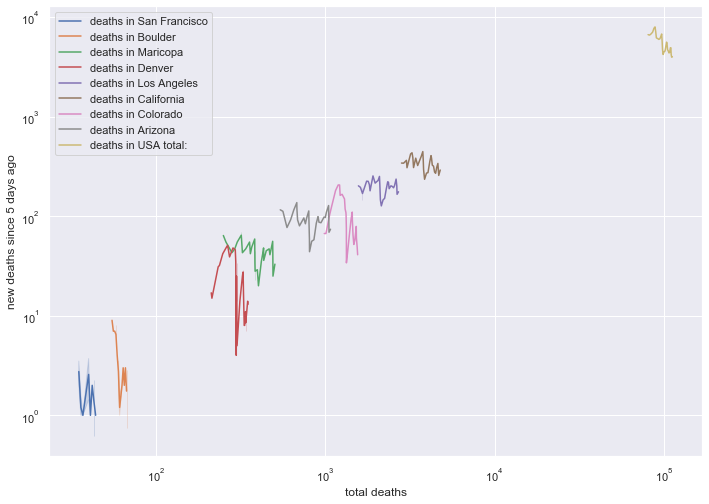


### Analysis for San Francisco ###

San Francisco cases exponential formula fitted with 30 points:
cases = 1960.71 * exp(0.0128 * day)
fitted daily growth rate: 1.29 %, fitted days to doubling: 54.07
actual daily growth rate: 1.09 %, actual days to doubling: 63.72


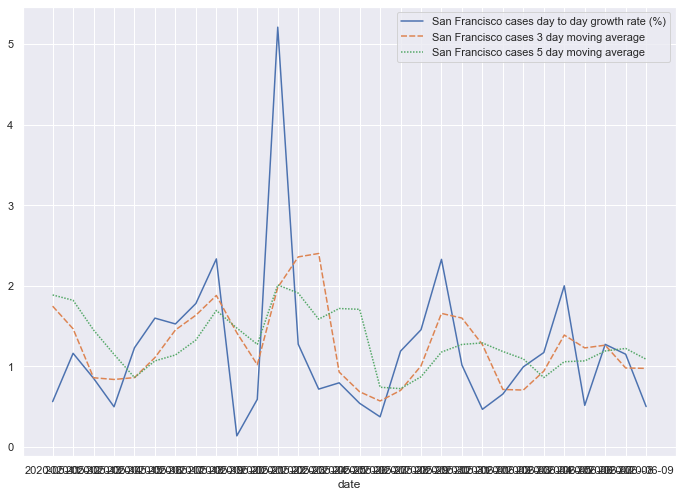

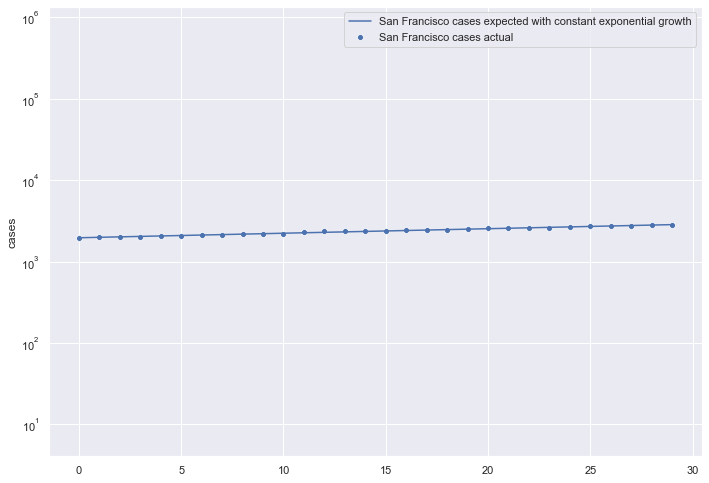

San Francisco deaths exponential formula fitted with 30 points:
deaths = 34.68 * exp(0.0088 * day)
fitted daily growth rate: 0.89 %, fitted days to doubling: 78.54
actual daily growth rate: 0.45 %, actual days to doubling: 152.49


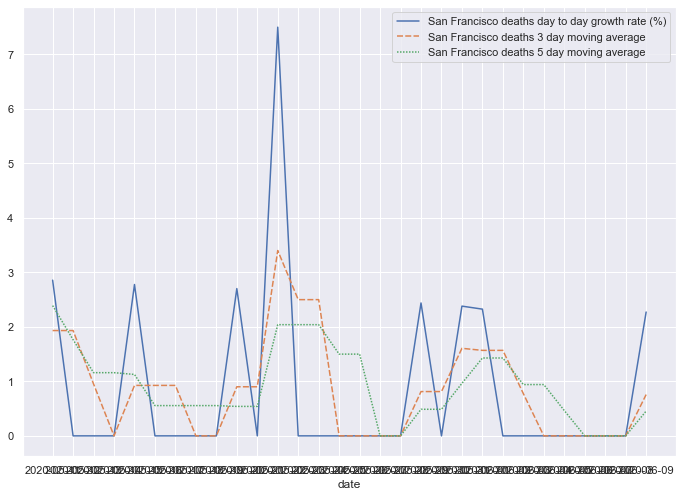

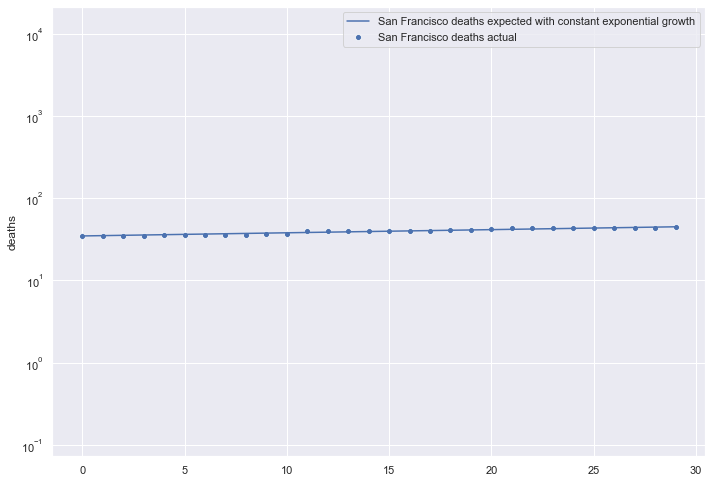

Trajectory plots for San Francisco, to see when the curve starts flattening


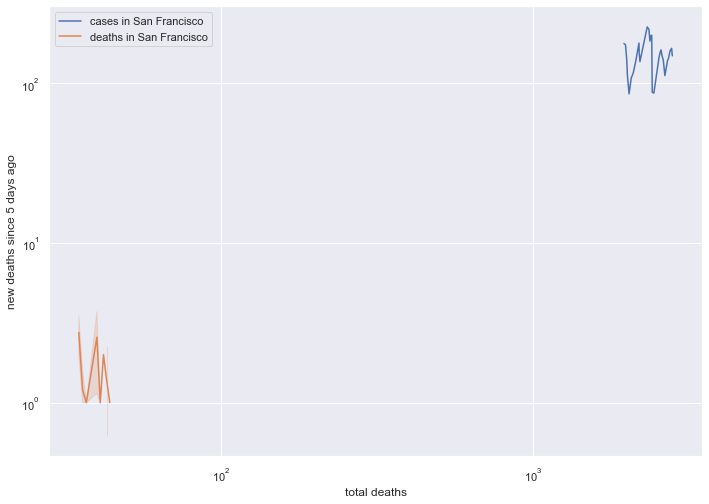


### Analysis for Boulder ###

Boulder cases exponential formula fitted with 30 points:
cases = 798.83 * exp(0.0097 * day)
fitted daily growth rate: 0.97 %, fitted days to doubling: 71.82
actual daily growth rate: 0.45 %, actual days to doubling: 153.38


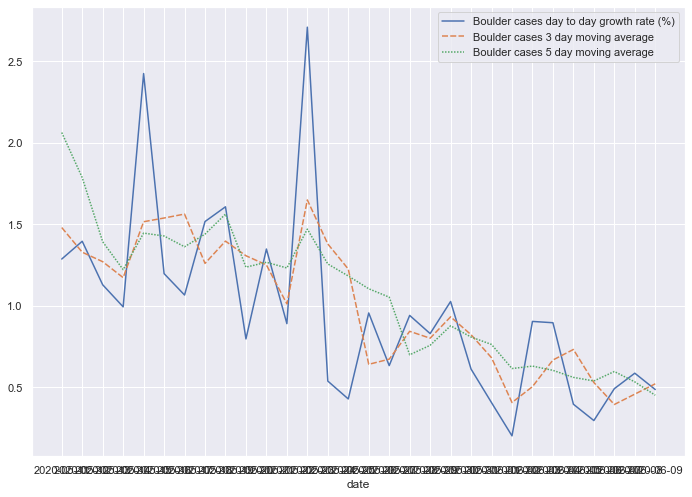

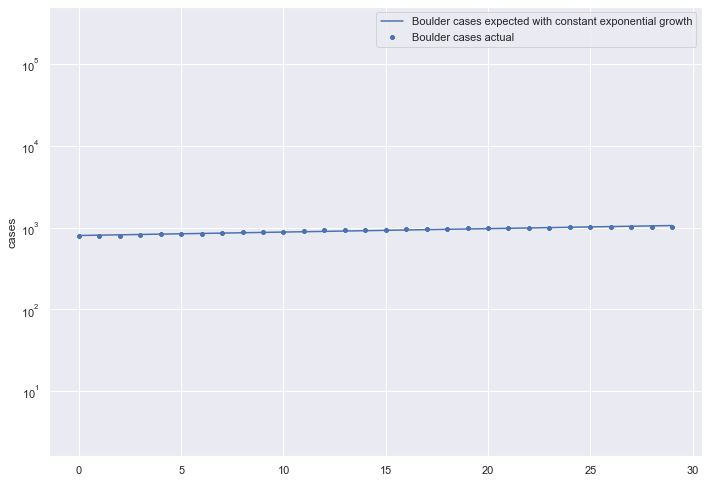

Boulder deaths exponential formula fitted with 30 points:
deaths = 56.52 * exp(0.0067 * day)
fitted daily growth rate: 0.67 %, fitted days to doubling: 103.97
actual daily growth rate: 0.0 %, actual days to doubling: inf


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


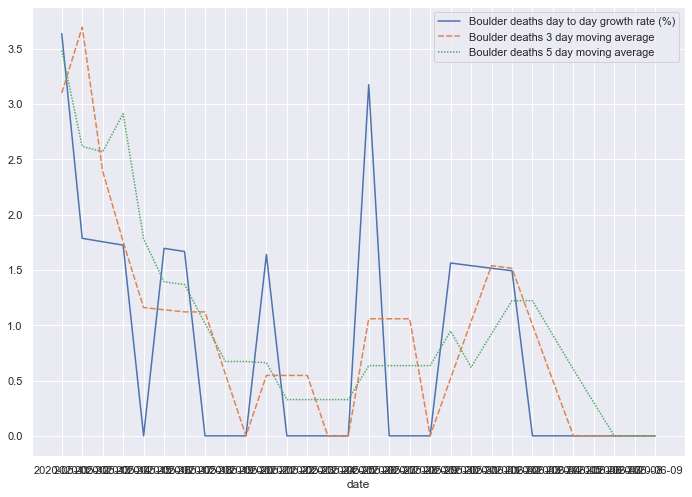

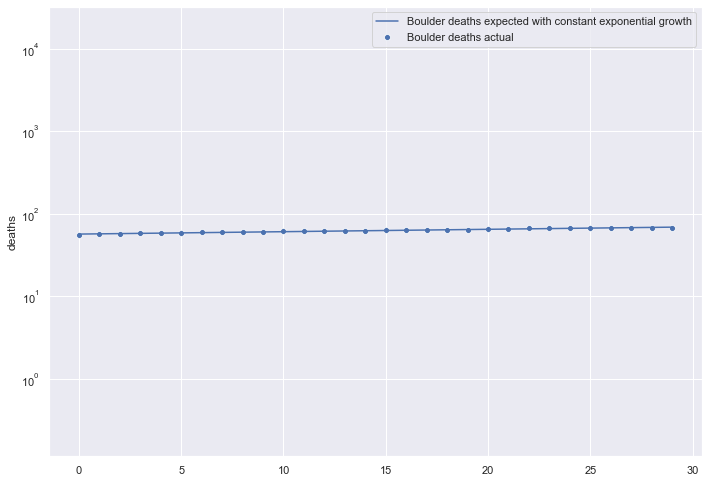

Trajectory plots for Boulder, to see when the curve starts flattening


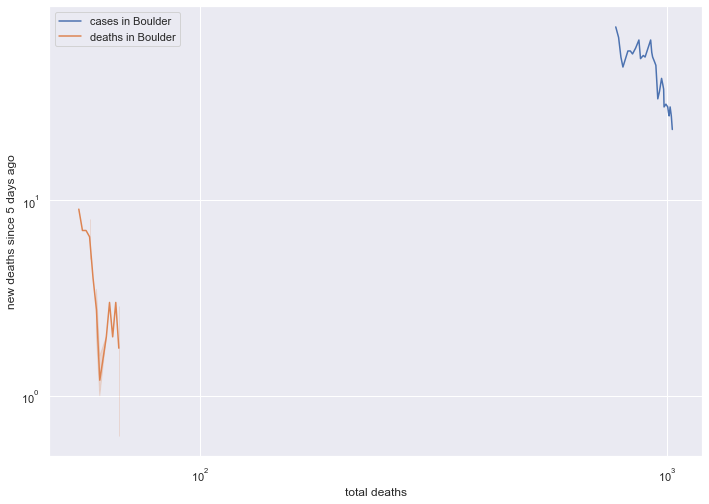


### Analysis for Maricopa ###

Maricopa cases exponential formula fitted with 30 points:
cases = 5914.18 * exp(0.0277 * day)
fitted daily growth rate: 2.81 %, fitted days to doubling: 25.04
actual daily growth rate: 4.81 %, actual days to doubling: 14.42


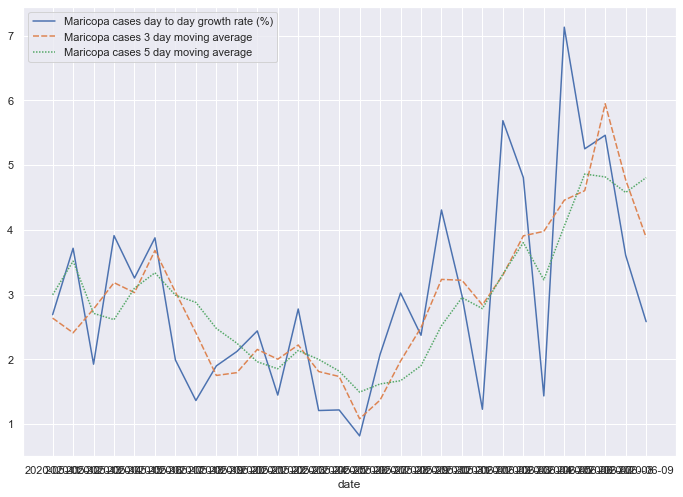

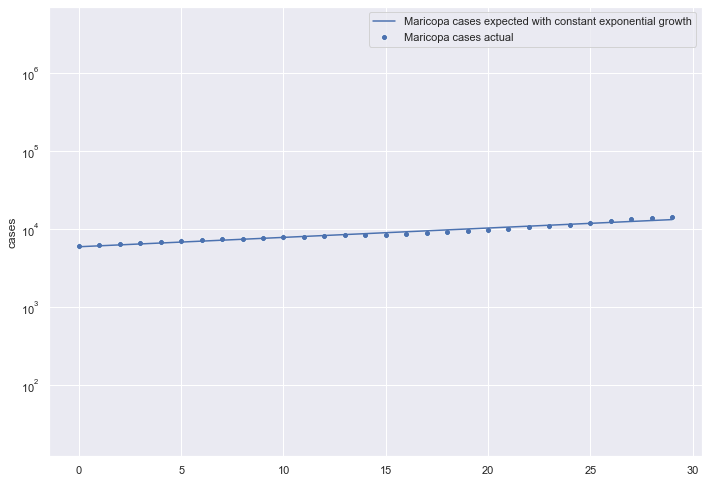

Maricopa deaths exponential formula fitted with 30 points:
deaths = 276.43 * exp(0.0222 * day)
fitted daily growth rate: 2.25 %, fitted days to doubling: 31.2
actual daily growth rate: 1.34 %, actual days to doubling: 51.71


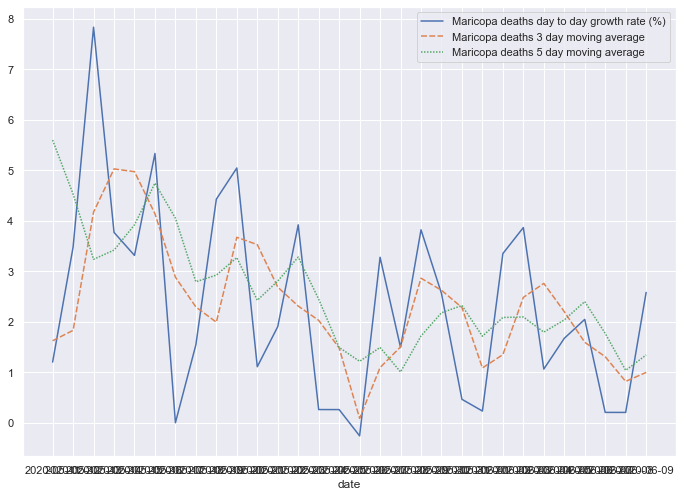

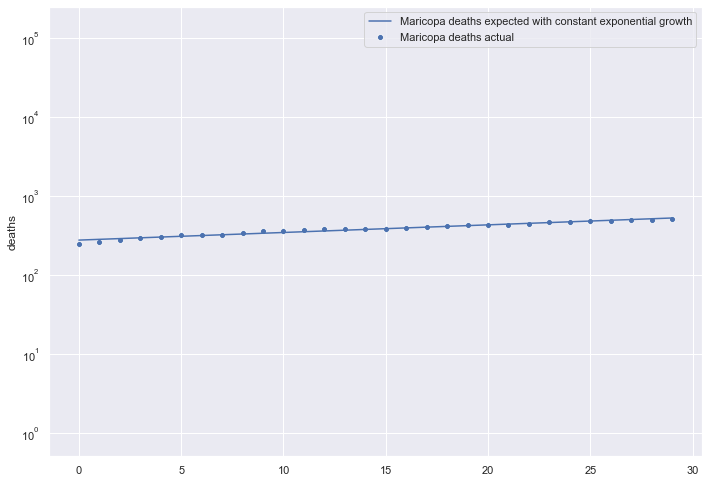

Trajectory plots for Maricopa, to see when the curve starts flattening


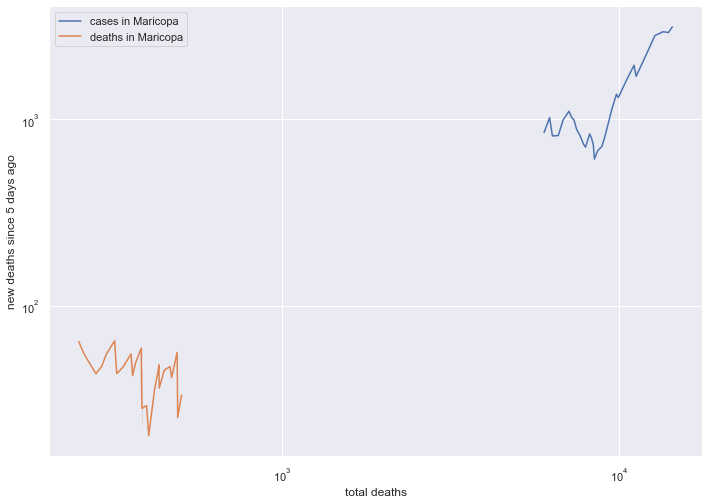


### Analysis for Denver ###

Denver cases exponential formula fitted with 30 points:
cases = 4236.47 * exp(0.0143 * day)
fitted daily growth rate: 1.44 %, fitted days to doubling: 48.41
actual daily growth rate: 0.65 %, actual days to doubling: 106.2


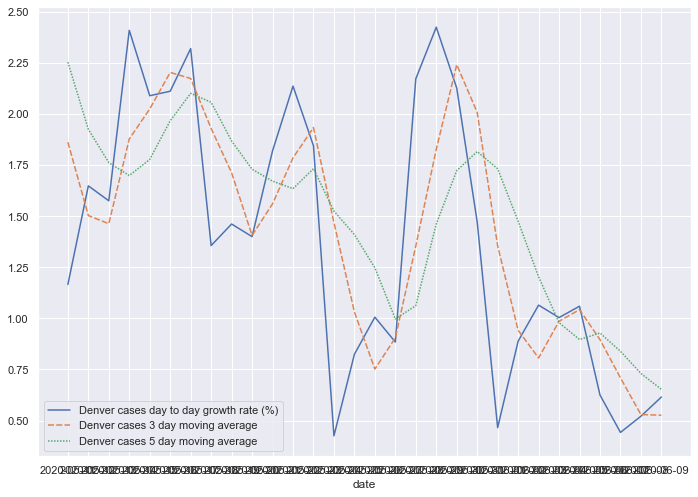

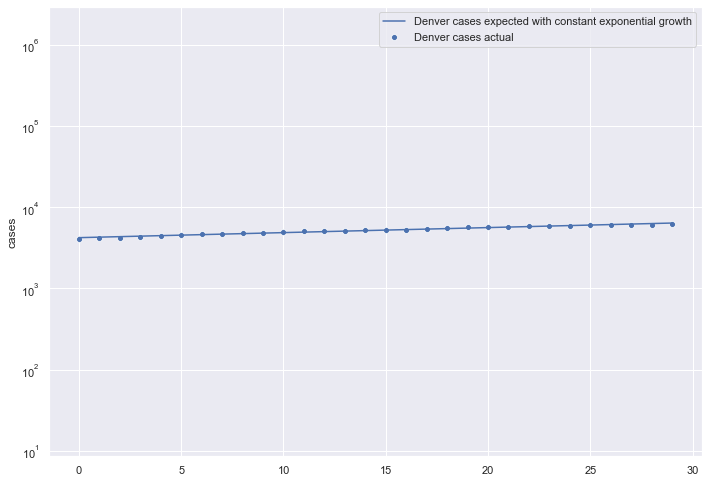

Denver deaths exponential formula fitted with 30 points:
deaths = 237.57 * exp(0.0152 * day)
fitted daily growth rate: 1.54 %, fitted days to doubling: 45.48
actual daily growth rate: 0.75 %, actual days to doubling: 92.19


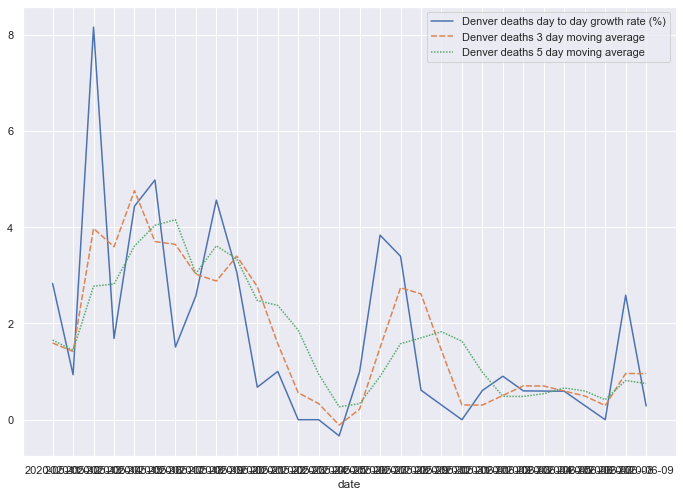

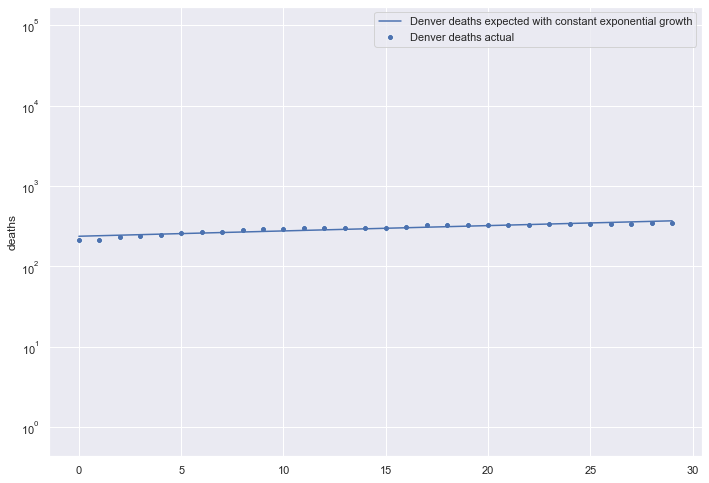

Trajectory plots for Denver, to see when the curve starts flattening


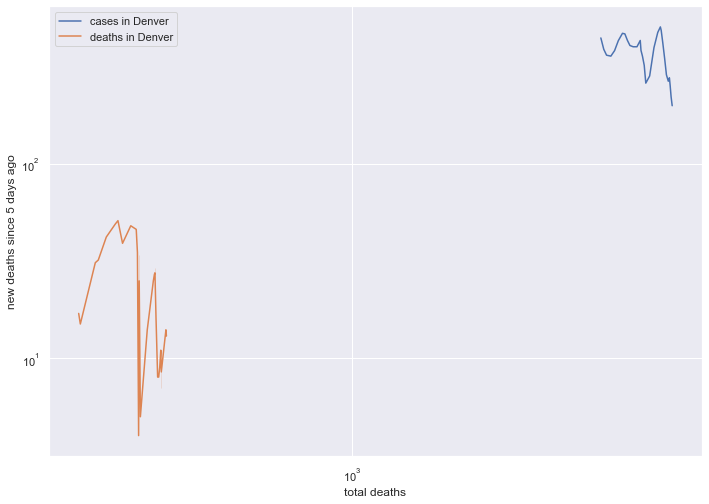


### Analysis for Los Angeles ###

Los Angeles cases exponential formula fitted with 30 points:
cases = 32658.43 * exp(0.025 * day)
fitted daily growth rate: 2.53 %, fitted days to doubling: 27.73
actual daily growth rate: 1.95 %, actual days to doubling: 35.56


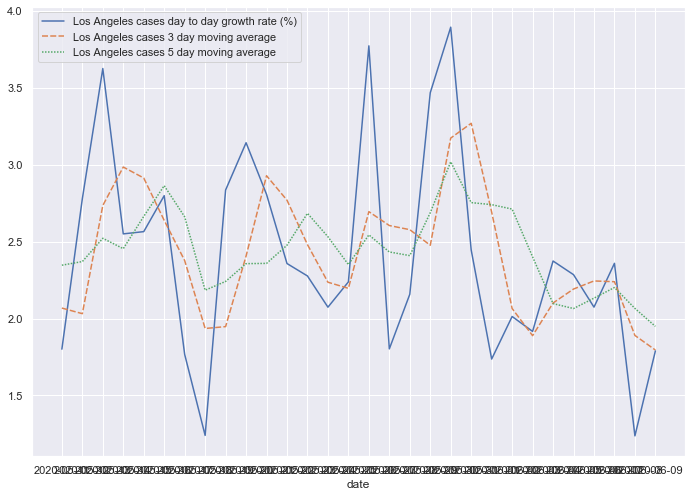

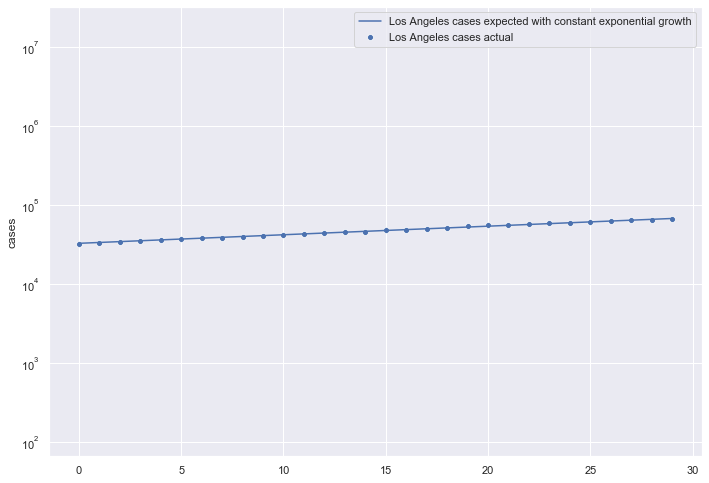

Los Angeles deaths exponential formula fitted with 30 points:
deaths = 1626.09 * exp(0.0185 * day)
fitted daily growth rate: 1.86 %, fitted days to doubling: 37.54
actual daily growth rate: 1.33 %, actual days to doubling: 51.98


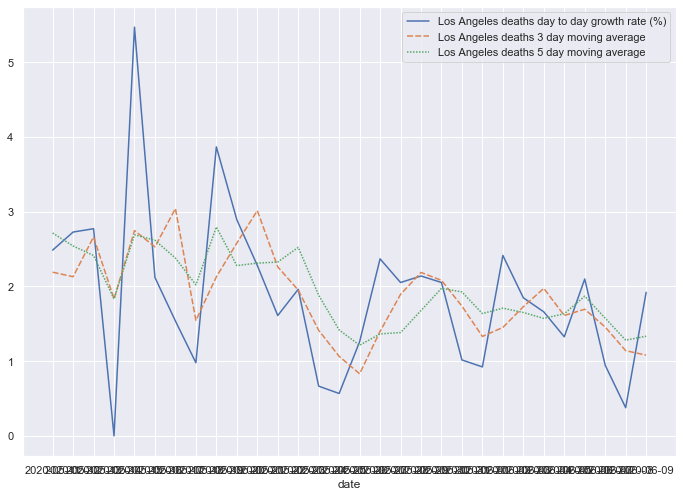

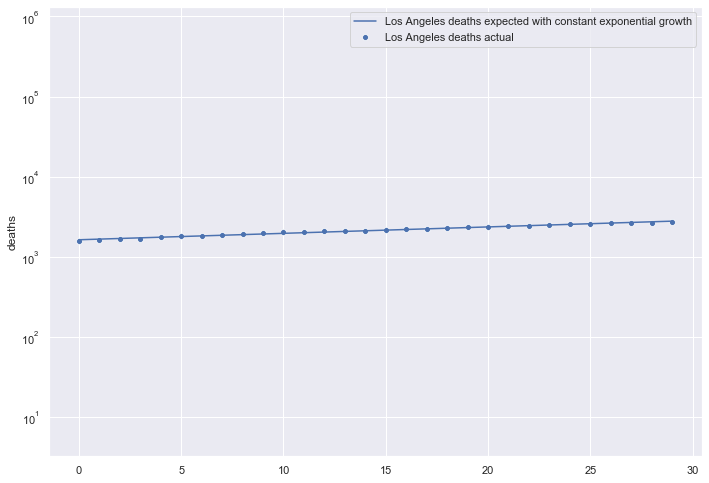

Trajectory plots for Los Angeles, to see when the curve starts flattening


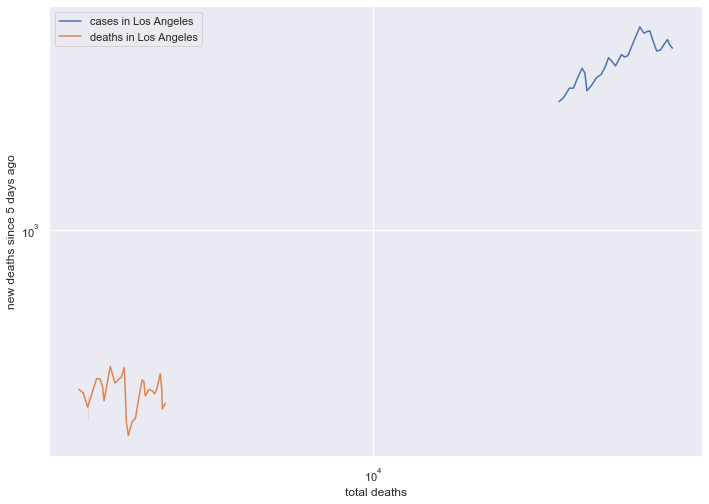


### Analysis for California ###

California cases exponential formula fitted with 30 points:
cases = 69790.06 * exp(0.0237 * day)
fitted daily growth rate: 2.4 %, fitted days to doubling: 29.28
actual daily growth rate: 2.18 %, actual days to doubling: 31.82


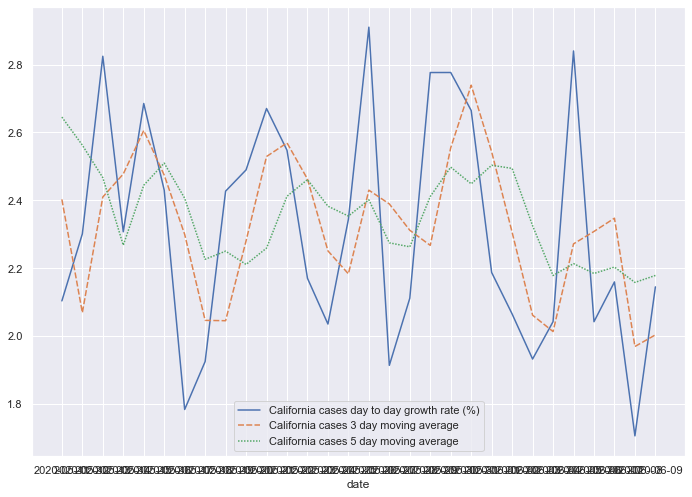

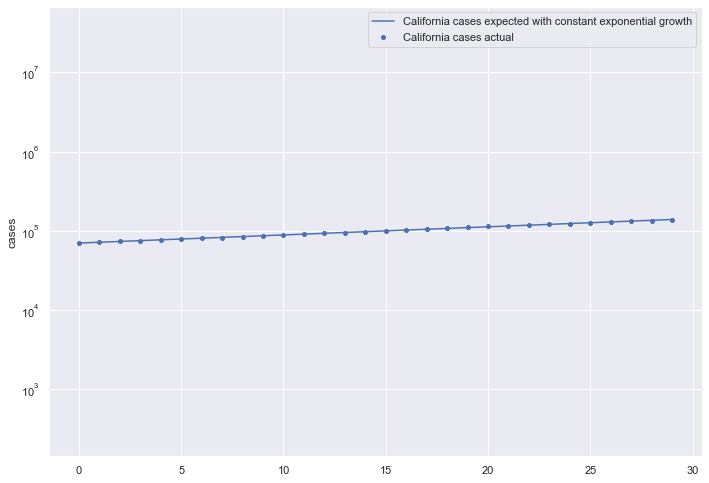

California deaths exponential formula fitted with 30 points:
deaths = 2955.87 * exp(0.0176 * day)
fitted daily growth rate: 1.77 %, fitted days to doubling: 39.44
actual daily growth rate: 1.25 %, actual days to doubling: 55.54


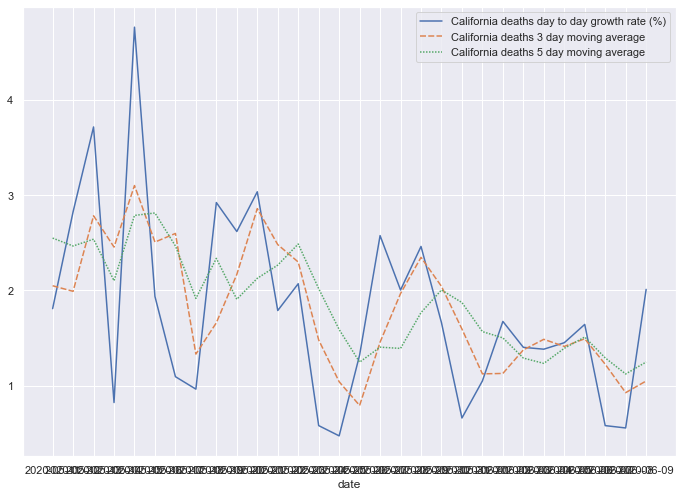

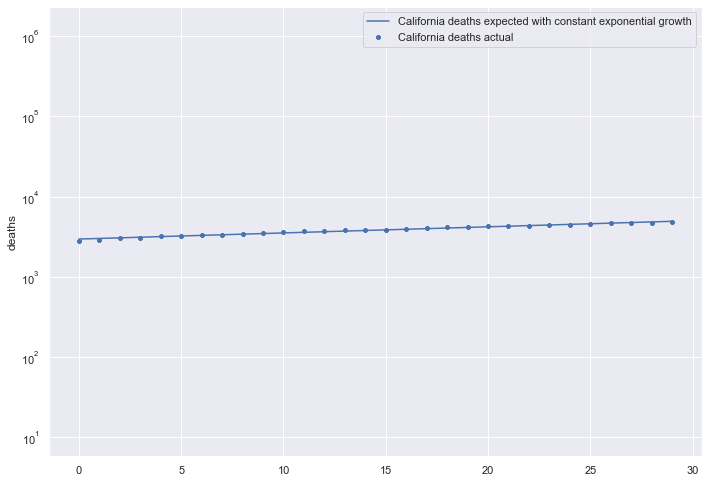

Trajectory plots for California, to see when the curve starts flattening


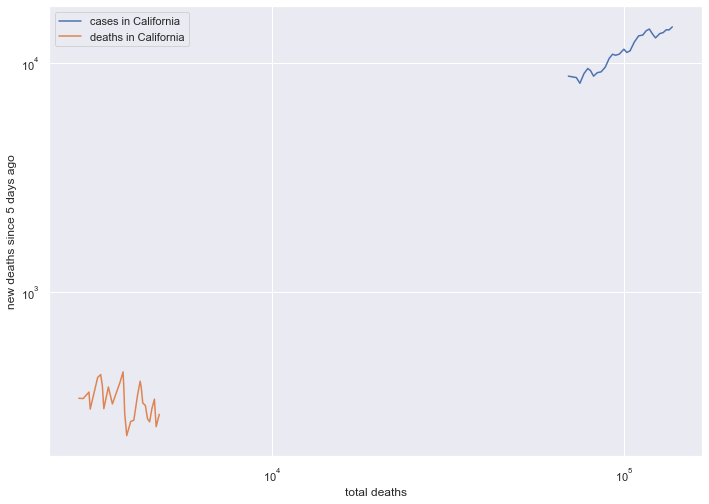


### Analysis for Colorado ###

Colorado cases exponential formula fitted with 30 points:
cases = 20239.64 * exp(0.0125 * day)
fitted daily growth rate: 1.26 %, fitted days to doubling: 55.36
actual daily growth rate: 0.71 %, actual days to doubling: 98.11


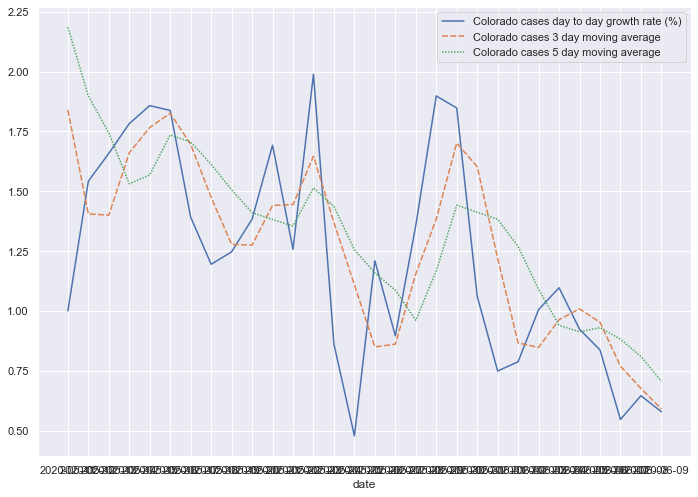

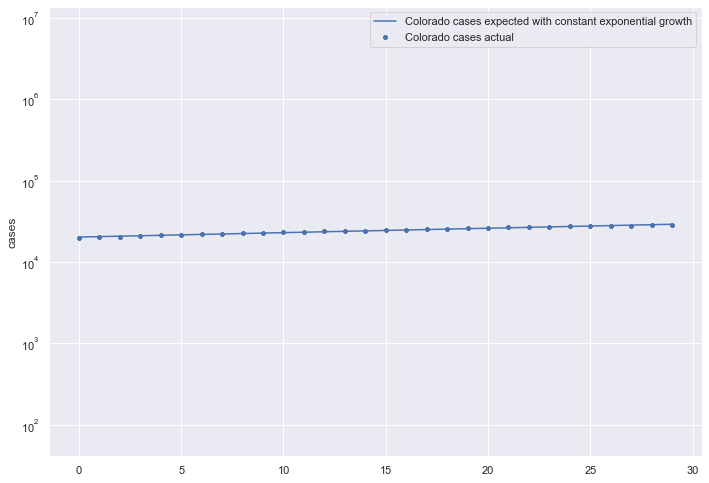

Colorado deaths exponential formula fitted with 30 points:
deaths = 1084.66 * exp(0.0141 * day)
fitted daily growth rate: 1.42 %, fitted days to doubling: 49.28
actual daily growth rate: 0.53 %, actual days to doubling: 130.06


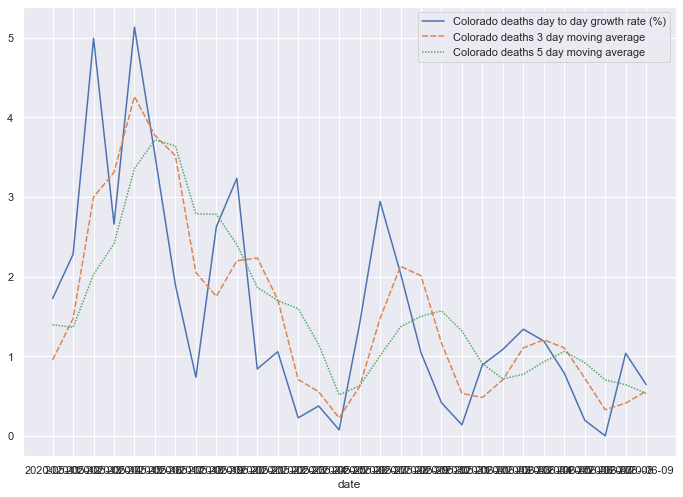

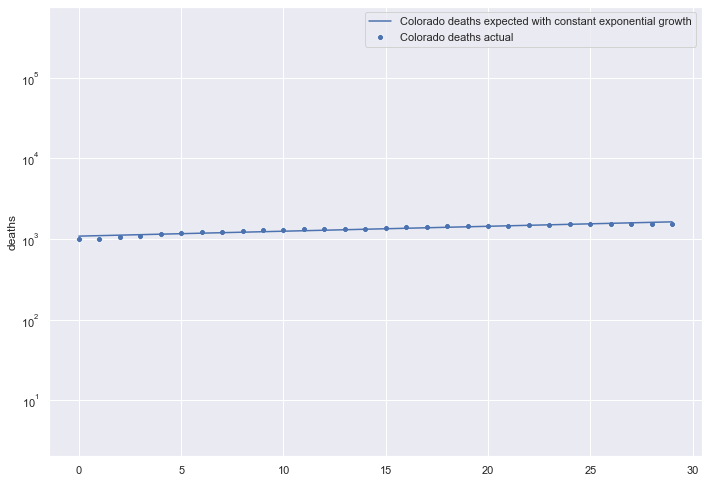

Trajectory plots for Colorado, to see when the curve starts flattening


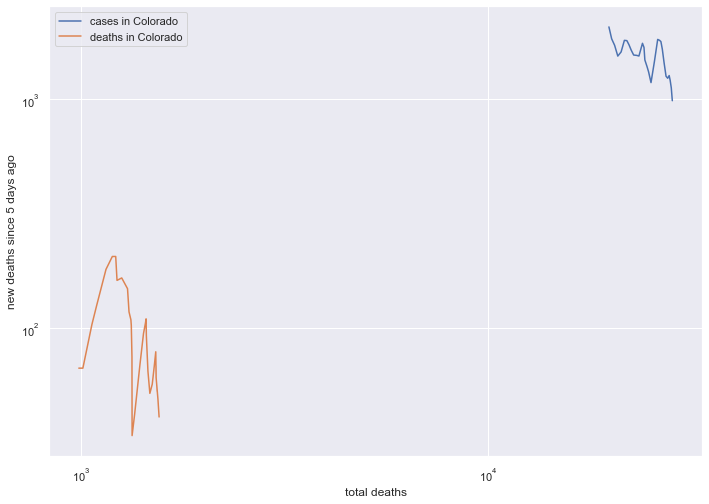


### Analysis for Arizona ###

Arizona cases exponential formula fitted with 30 points:
cases = 11317.97 * exp(0.0298 * day)
fitted daily growth rate: 3.02 %, fitted days to doubling: 23.29
actual daily growth rate: 4.27 %, actual days to doubling: 16.24


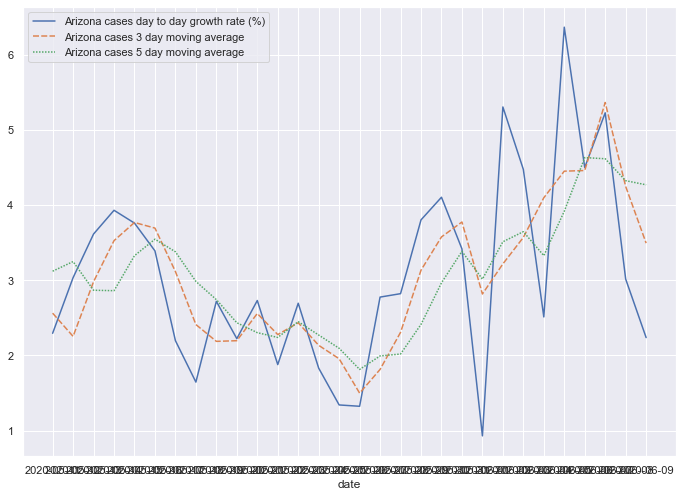

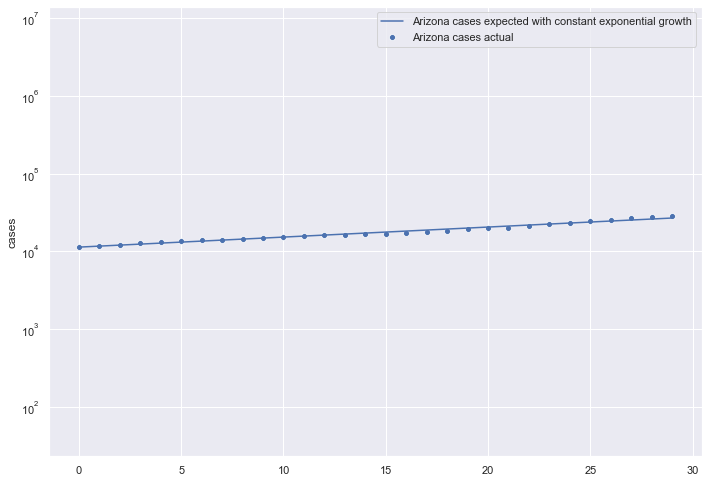

Arizona deaths exponential formula fitted with 30 points:
deaths = 586.92 * exp(0.022 * day)
fitted daily growth rate: 2.23 %, fitted days to doubling: 31.45
actual daily growth rate: 1.41 %, actual days to doubling: 49.07


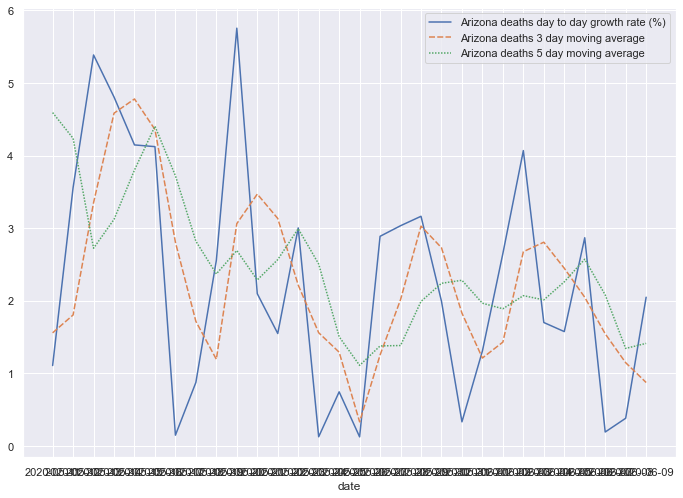

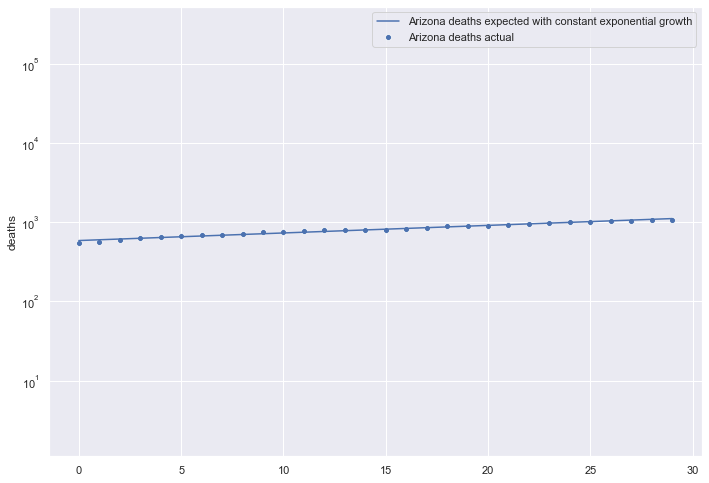

Trajectory plots for Arizona, to see when the curve starts flattening


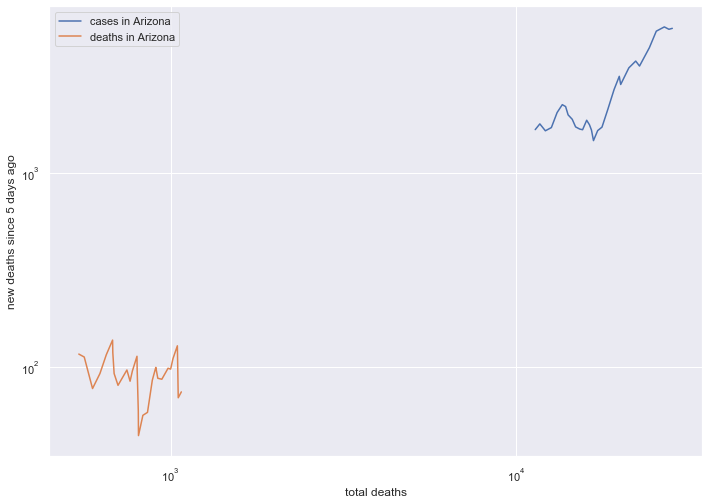


### Analysis for USA total: ###

USA total: cases exponential formula fitted with 30 points:
cases = 1377562.19 * exp(0.0132 * day)
fitted daily growth rate: 1.33 %, fitted days to doubling: 52.61
actual daily growth rate: 1.1 %, actual days to doubling: 63.07


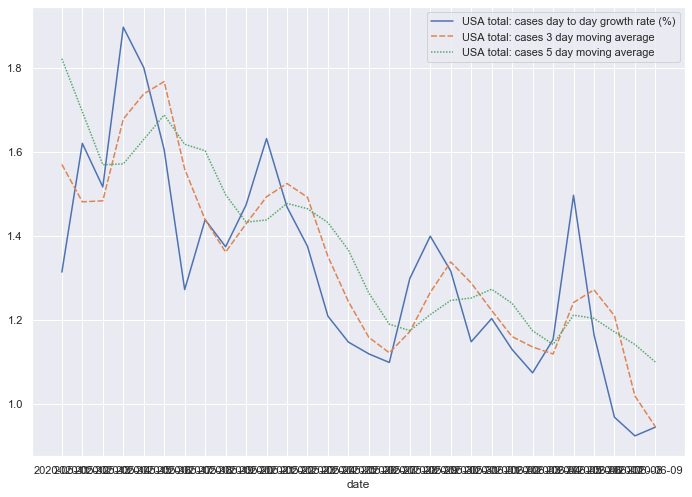

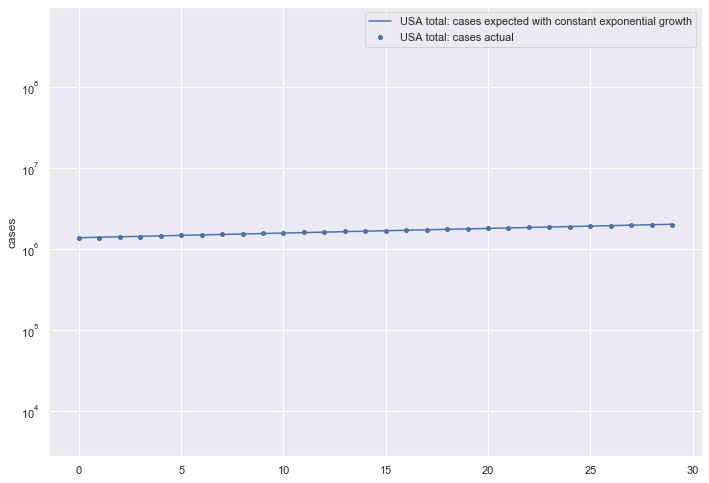

USA total: deaths exponential formula fitted with 30 points:
deaths = 83637.51 * exp(0.0108 * day)
fitted daily growth rate: 1.09 %, fitted days to doubling: 63.93
actual daily growth rate: 0.72 %, actual days to doubling: 96.2


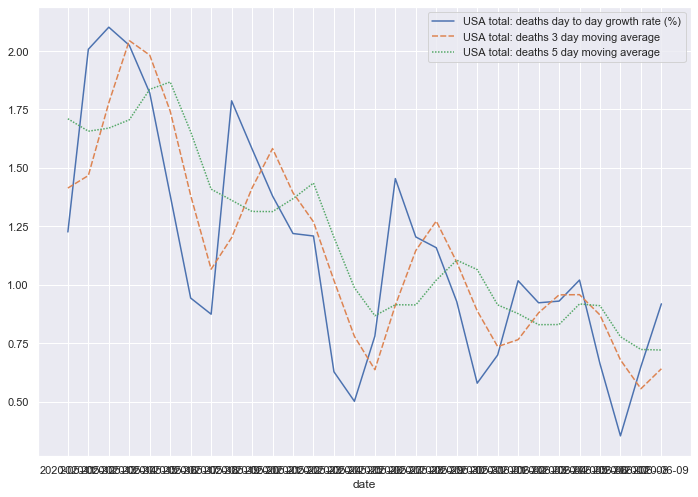

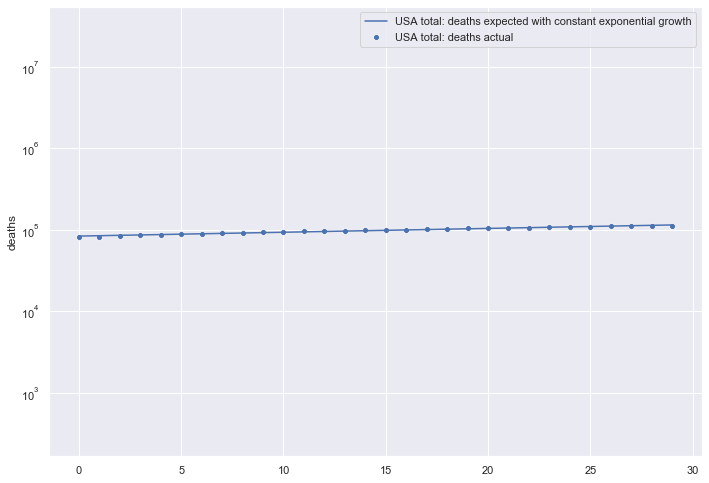

Trajectory plots for USA total:, to see when the curve starts flattening


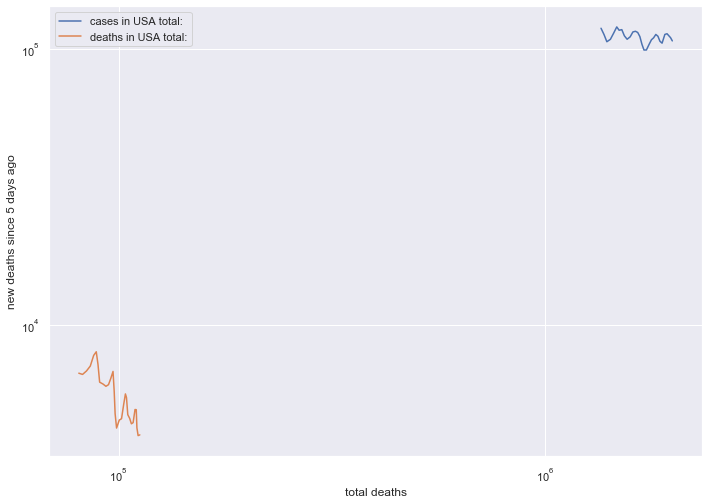

In [20]:
counties =["San Francisco", "Boulder", "Maricopa", "Denver", "Los Angeles"]
states = [ "California", "Colorado", "Arizona"]
analyse(counties=counties, states=states)